In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gpflow
import pickle
import os
import scipy
from GPSat.models import GPR_OptimalInterpolation
from mpl_toolkits.axes_grid1 import make_axes_locatable

2022-11-08 21:31:15.046543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 21:31:15.174511: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 21:31:15.699329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64
2022-11-08 21:31:15.699380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; d

In [4]:
########## Process data ##########

# --- Read auxiliary data

# Get SIE mask
data_dir = "/home/so/Documents/Projects/GPSat/data/sea_ice_data/"
pkl_file = "aux/SIE/SIE_masking_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    SIE = pickle.load(f) # Dictionary {date: array}
dates = list(SIE.keys())

# Get x, y coordinates
x_file = os.path.join(data_dir, "aux/new_x_50km.npy")
y_file = os.path.join(data_dir, "aux/new_y_50km.npy")
xgrid = np.load(x_file)
ygrid = np.load(y_file)
xcoords = xgrid[0,:]
ycoords = ygrid[:,0]

# --- Get satellite observations (CS2_SAR, CS2_SARIN, S3A, S3B)

# CS2 SAR
pkl_file = "CS2S3_CPOM/CS2_SAR_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    CS2_SAR = pickle.load(f) # Dictionary {date: array}

# CS2_SARIN
pkl_file = "CS2S3_CPOM/CS2_SARIN_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    CS2_SARIN = pickle.load(f) # Dictionary {date: array}

# S3A
pkl_file = "CS2S3_CPOM/S3A_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    S3A = pickle.load(f) # Dictionary {date: array}

# S3B
pkl_file = "CS2S3_CPOM/S3B_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    S3B = pickle.load(f) # Dictionary {date: array}

# --- Convert data to numpy arrays (following Will's code)

obs = []
zb = []
dates = []
for key in CS2_SAR:
    if (key in CS2_SARIN) & (key in S3A) & (key in S3B):
        obs.append([CS2_SAR[key],CS2_SARIN[key],S3A[key],S3B[key]])
        zb.append(SIE[key])
        dates.append(key)
obs = np.array(obs).transpose(2,3,0,1) # (x, y, t, sat)
zb = np.array(zb).transpose(1,2,0)
zb[zb<0.15] = np.nan

T=9 # 9 days of data are used to train the model. You could test varying this. Could maybe get away with 5 or 7.
T_mid=T//2 # interpolate on the central day
dX, dY = obs.shape[0], obs.shape[1]
first_day = 100 #training data starts at day = 1
zb_day = zb[:,:,first_day+T_mid] #this is the sea ice extent mask on the day we are interpolating (i.e., we need to make sure there is sea ice where we want to estimate freeboard)
sat = obs[:,:,first_day:first_day+T,:] #the T days of training data from all satellites

# this next part loops over all T days of training data and appends all the inputs/outputs into long vectors
x1 = [] ; y1 = [] ; t1 = [] ; z1 = []
x2 = [] ; y2 = [] ; t2 = [] ; z2 = []
x3 = [] ; y3 = [] ; t3 = [] ; z3 = []
x4 = [] ; y4 = [] ; t4 = [] ; z4 = []
for day in range(sat.shape[3]):
    IDs_1 = np.where(~np.isnan(sat[:,:,day,0]))
    IDs_2 = np.where(~np.isnan(sat[:,:,day,1]))
    IDs_3 = np.where(~np.isnan(sat[:,:,day,2]))
    IDs_4 = np.where(~np.isnan(sat[:,:,day,3]))
    x1.extend(xgrid[IDs_1]) ; x2.extend(xgrid[IDs_2]) ; x3.extend(xgrid[IDs_3]) ; x4.extend(xgrid[IDs_4])
    y1.extend(ygrid[IDs_1]) ; y2.extend(ygrid[IDs_2]) ; y3.extend(ygrid[IDs_3]) ; y4.extend(ygrid[IDs_4])
    t1.extend(np.ones(np.shape(IDs_1)[1])*day) ; t2.extend(np.ones(np.shape(IDs_2)[1])*day) ; t3.extend(np.ones(np.shape(IDs_3)[1])*day) ; t4.extend(np.ones(np.shape(IDs_4)[1])*day)
    z1.extend(sat[:,:,day,0][IDs_1]) ; z2.extend(sat[:,:,day,1][IDs_2]) ; z3.extend(sat[:,:,day,2][IDs_3]) ; z4.extend(sat[:,:,day,3][IDs_4])
x_train = np.concatenate((x1,x2,x3,x4))
y_train = np.concatenate((y1,y2,y3,y4))
t_train = np.concatenate((t1,t2,t3,t4))
z_train = np.concatenate((z1,z2,z3,z4)).reshape(-1,1)

# Test points
IDs = np.where(~np.isnan(zb_day))
X_test = np.array([xgrid[IDs],ygrid[IDs]]).T

xy_train = np.array([x_train,y_train]).T
X_tree = scipy.spatial.cKDTree(xy_train)


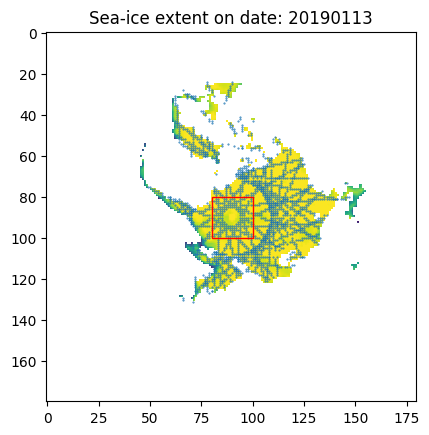

In [5]:
# Choose small region to test over
test_day = first_day + T_mid # Test date
xmin = 80; xmax = 100; ymin=80; ymax=100 # Region
Nx = xmax-xmin
Ny = ymax-ymin
x_test = np.array([xgrid[0,j] for j in range(xmin, xmax)])
y_test = np.array([ygrid[i,0] for i in range(ymin, ymax)])

x_idxs = []; y_idxs = []
for i in range(4):
    x, y = np.where(np.isnan(obs[:,:,test_day,i]) == False)
    x_idxs.extend(x); y_idxs.extend(y)
x_idxs = np.array(x_idxs); y_idxs = np.array(y_idxs)

# Plot sea ice extent at given date, selected region and satellite observatiosn
plt.imshow(zb[:,:,test_day].transpose())
plt.scatter(x_idxs, y_idxs, s=0.2)
plt.title(f"Sea-ice extent on date: {dates[test_day]}")
rect = patches.Rectangle((xmin, ymin), Nx, Ny, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.show()

In [6]:
# Set up OI model
X = np.stack([x_train, y_train, t_train], axis=1)
z = z_train.reshape(-1,1)
init_hyperparameters = {'lengthscale_x': 50*1000, 'lengthscale_y': 50*1000, 'lengthscale_t': 1.0, 'kernel_variance': 1.0, 'observation_variance': 1.0}

f = GPR_OptimalInterpolation(training_data=(X,z),
                             kernel=gpflow.kernels.Matern32,
                             init_hyperparameters=init_hyperparameters)


In [7]:
# Model training
trainable_hyperparameters = ['lengthscale_x', 'lengthscale_y', 'lengthscale_t', 'kernel_variance', 'observation_variance']

postprocess_kwargs = {'lengthscale_x': {'vmin': 1, 'vmax': 2 * 300 * 1000, 'std': 1},
                      'lengthscale_y': {'vmin': 1, 'vmax': 2 * 300 * 1000, 'std': 1},
                      'lengthscale_t': {'vmin': 0.1, 'vmax': 9, 'std': 1},
                      'kernel_variance': {'vmin': 2e-6, 'vmax': 0.1, 'std': 1},
                      'observation_variance': {'vmin': 2e-6, 'vmax': 0.05, 'std': 1}
                      }

f.train(dates=[dates[test_day]],
        region=xr.Dataset(coords={"x": x_test, "y": y_test}),
        trainable_hyperparameters=trainable_hyperparameters,
        postprocess_kwargs=postprocess_kwargs)


Training on date: 20190113


/home/so/Documents/Projects/SparseOptimalInterpolation/.venv/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-11-08 21:31:46.708971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 21:31:47.593385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 541 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-11-08 21:31:47.594963: I tensorflow/core/common_runtime/gpu/gpu_device.

: 

: 

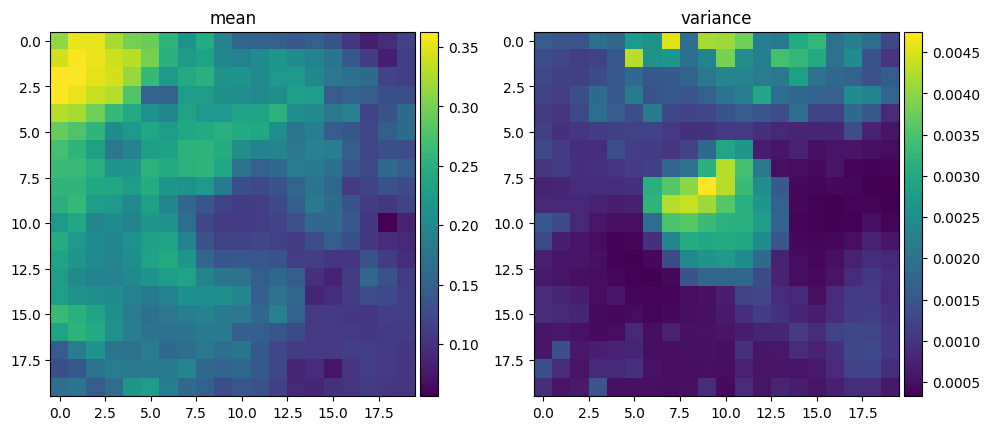

In [6]:
# Make predictions on test region
gridded_mean, gridded_var = f.predict(dates=[dates[test_day]],
                                      region=xr.Dataset(coords={"x": x_test, "y": y_test}))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
im1 = ax1.imshow(gridded_mean[0])
ax1.set_title('mean')
im2 = ax2.imshow(gridded_var[0])
ax2.set_title('variance')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()

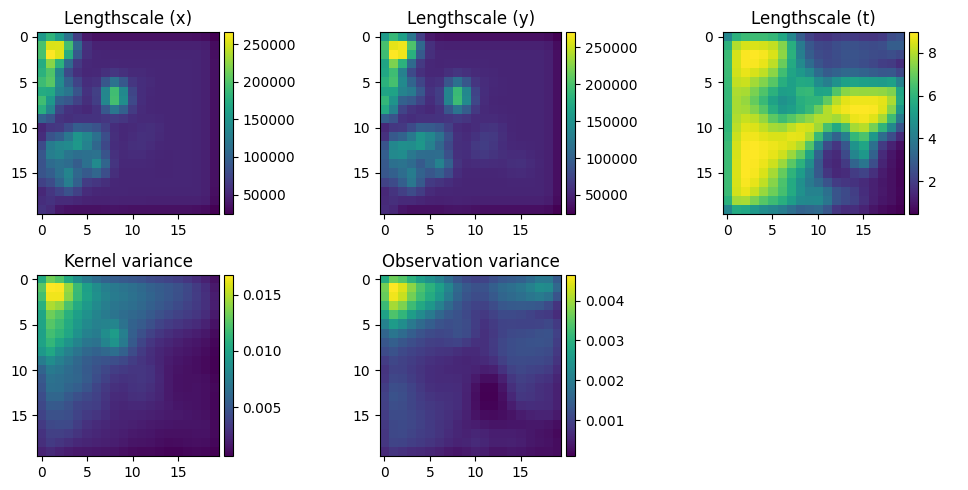

In [10]:
# Plot hyperparameter fields
ds = xr.open_dataset(f'log/hyperparameters_{dates[test_day]}_50km.nc')
fig, axs = plt.subplots(2,3, figsize=(10,5))

def add_colorbar(image, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(image, cax=cax, orientation='vertical') 

im1 = axs[0,0].imshow(ds['lengthscale_x'])
axs[0,0].set_title('Lengthscale (x)')
add_colorbar(im1, axs[0,0])

im2 = axs[0,1].imshow(ds['lengthscale_y'])
axs[0,1].set_title('Lengthscale (y)')
add_colorbar(im2, axs[0,1])

im3 = axs[0,2].imshow(ds['lengthscale_t'])
axs[0,2].set_title('Lengthscale (t)')
add_colorbar(im3, axs[0,2])

im4 = axs[1,0].imshow(ds['kernel_variance'])
axs[1,0].set_title('Kernel variance')
add_colorbar(im4, axs[1,0])

im5 = axs[1,1].imshow(ds['observation_variance'])
axs[1,1].set_title('Observation variance')
add_colorbar(im5, axs[1,1])

axs[1,2].set_axis_off()

plt.tight_layout()

plt.show()